In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import matplotlib.lines as mlines
from skimage import measure

In [7]:
fig_width_pt = 2*246.0  
inches_per_pt = 1.0 / 72.27
golden_mean = (np.sqrt(5) - 1.0) / 2.0
fig_width = fig_width_pt * inches_per_pt
fig_height = fig_width * golden_mean
square_size = [fig_width, fig_width]
rect_size = [fig_width, fig_height]

rc_params = {'axes.labelsize': 18,
          'axes.titlesize': 24,
          'font.size': 18,
          'legend.fontsize': 18,
          'font.family': 'serif',
          'font.sans-serif': ['Bitstream Vera Sans'],
          'font.serif': ['Bitstream Vera'],
          'xtick.labelsize': 18,
          'ytick.labelsize': 18,
          'text.usetex': True,
          'text.latex.preamble': r"""\usepackage{amsmath} \usepackage{amssymb} \usepackage{amsfonts}""",
          'figure.figsize': rect_size,
         }
plt.rcParams.update(rc_params)

In [9]:
yearinseconds= 31557600.0
Tobs = yearinseconds*4
dof = 1000
fmin = 10**-4
fmax = 10**-2
df = dof / Tobs
freq = np.arange(fmin, fmax, df)
L = 8.3
c = 299792458.0
H02 = (69.8*1e3/ (3.08 * 1e22))**2
f0 = 10**-2.5

In [11]:
def get_contour(file, statistics = 'BF'):
    data = np.loadtxt(file)
    A , G,  BF_tot, snr, __ = data[0], data[1],  data[2], data[3], data[4]
    if statistics == 'SNR':
        rho = [10, 100, 1000]
        # Create a grid for interpolation
        grid_x, grid_y = np.mgrid[min(G):max(G):500j, min(A):max(A):500j]  # create a grid
        grid_c = griddata((G, A), snr, (grid_x, grid_y), method='cubic')  # interpolate values
        pls_snr_ = []
        cont_x = []
        cont_y = []
        for i in rho:    
            contours = measure.find_contours(grid_c.T, i)
            x_coords = np.interp(contours[0][:, 1], np.arange(grid_c.shape[1]), grid_x.T[0])
            y_coords = np.interp(contours[0][:, 0], np.arange(grid_c.shape[0]), grid_y[0]) 
            pls = np.zeros((len(x_coords), len(freq)))
            for j in range(len(x_coords)):
                pls[j] = 10**y_coords[j]*(freq/f0)**x_coords[j]
            cont_x.append(x_coords)
            cont_y.append(y_coords)
            pls_snr_.append(np.max(pls,axis=0)*(0.67)**2)
        return pls_snr_, cont_x, cont_y
    if statistics == 'BF':
        grid_x, grid_y = np.mgrid[min(G):max(G):500j, min(A):max(A):500j]
        grid_c = griddata((G, A), BF_tot, (grid_x, grid_y), method='cubic')  # interpolate values
        bounds = [ 0.5, 1,  2]
        pls_bayes_10= []
        gamma_max= []
        cont_x = []
        cont_y = []
        for i in bounds:    
            contours = measure.find_contours(grid_c.T, i)
            x_coords = np.interp(contours[0][:, 1], np.arange(grid_c.shape[1]), grid_x.T[0])
            y_coords = np.interp(contours[0][:, 0], np.arange(grid_c.shape[0]), grid_y[0]) 
            pls = np.zeros((len(x_coords), len(freq)))
            for j in range(len(x_coords)):
                pls[j] = 10**y_coords[j]*(freq/f0)**x_coords[j]
            cont_x.append(x_coords)
            cont_y.append(y_coords)
            pls_bayes_10.append(np.max(pls,axis=0)*(0.67)**2)
            gamma_max.append(np.argmax(pls,axis=0))
        return pls_bayes_10, cont_x, cont_y

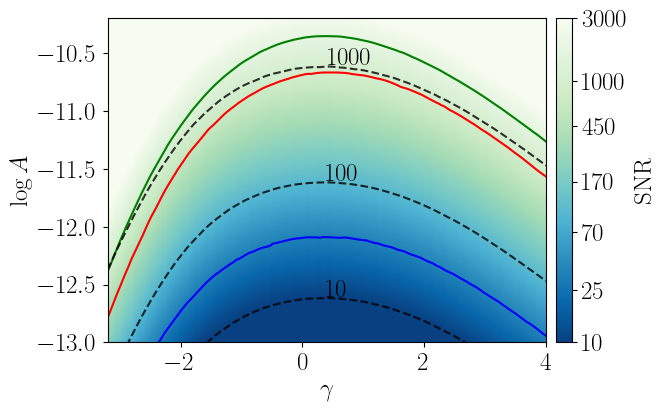

In [12]:
pls_snr_10, x_coords, y_coords = get_contour('../../data/pls_data_nu10.txt', 'SNR')
pls_snr_10_, x_coords2, y_coords2 = get_contour('../../data/pls_data_nu8.txt', 'SNR')
pls_bayes_7, x_coords7, y_coords7 = get_contour('../../data/pls_data_nu7_2.txt')
pls_bayes_8, x_coords8, y_coords8 = get_contour('../../data/pls_data_nu8_2.txt')
pls_bayes_10, x_coords10, y_coords10  = get_contour('../../data/pls_data_nu10.txt')
data = np.loadtxt('../../data/pls_data_nu7_2.txt')

fig, ax = plt.subplots(figsize=rect_size)
A_snr , G_snr,  bf_tot, snr, _ = data[0], data[1],  data[2], data[3], data[4]

# Create a grid for interpolation
grid_x, grid_y = np.mgrid[-4:5:500j, -13.5:-10.2:500j]  # create a grid
grid_c = griddata((G_snr, A_snr), snr, (grid_x, grid_y), method='cubic')  # interpolate values
scat = ax.scatter(grid_x.flatten(), grid_y.flatten(), c = np.log10(grid_c.flatten()), vmin = np.log10(10), vmax = np.log10(3000), rasterized = True, marker = '.', cmap = 'GnBu_r')
cbar = fig.colorbar(scat, ax=ax, label="$\\rm{SNR}$", pad=0.02)
cbar.set_ticks(np.log10(np.array([  10,   25,   70,  170,
        450, 1000 , 3000])), labels=np.array([  10,   25,   70,  170,
        450, 1000 , 3000]))
ax.plot(x_coords7[1], y_coords7[1], c = 'g')
ax.plot(x_coords8[1], y_coords8[1], c = 'r')
ax.plot(x_coords10[1], y_coords10[1], c = 'b')
ax.plot(x_coords[0], y_coords[0], c = 'k', linestyle='--',alpha = 0.8)
ax.plot(x_coords2[1], y_coords2[1], c = 'k', linestyle='--', alpha = 0.8)
ax.plot(x_coords2[2], y_coords2[2], c = 'k', linestyle='--', alpha = 0.8)

cb = mlines.Line2D([], [], color='b', alpha = 0.5, label = r'$\nu \rightarrow 10 \%$', linestyle='-')
cr = mlines.Line2D([], [], color='r', alpha = 0.5, label = r'$\nu \rightarrow 25 \%$', linestyle='-')
cg = mlines.Line2D([], [], color='g', alpha = 0.5, label = r'$\nu \rightarrow 50 \%$', linestyle='-')

ind = np.argmax(y_coords[0])
__=plt.annotate("10", xy=(x_coords[0][ind], y_coords[0][ind]), xytext=(x_coords[0][ind], 0.999*y_coords[0][ind]))
ind = np.argmax(y_coords2[1])
__=plt.annotate("100", xy=(x_coords2[1][ind], y_coords2[1][ind]), xytext=(x_coords2[1][ind], 0.999*y_coords2[1][ind]))
ind = np.argmax(y_coords2[2])
__=plt.annotate("1000", xy=(x_coords2[2][ind], y_coords2[2][ind]), xytext=(x_coords2[2][ind], 0.999*y_coords2[2][ind]))

plt.xlabel('$\gamma$')
plt.ylabel('$\log A$')
plt.ylim(-13.0,-10.2)
plt.xlim(-3.2, 4)
plt.savefig('../../plots/par_space.pdf', bbox_inches='tight')